# Reto Grupo C

### Integrantes

- Álvaro Garnica Navarro
- Alejandro Martínez López
- Fernando Suárez
- Daniel Vera Nieto
- Sergio López López

# Introducción

En este notebook presentamos el resultado final que hemos obtenido y cómo lo hemos obtenido. En un primer lugar hemos realizado un exploring del dataset, analizando característica a característica. Después se ha hecho un preprocesamiento del dataset, donde se realizan técnicas de análisis de sentimientos. Y por último, se entrena el modelo consiguiendo una f-score de 0.63421 en la competición F1Macro - False Political Claim Detection

In [85]:
#Importing necessary libraries

import pandas         as pd
import numpy          as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import itertools

from imblearn.under_sampling import RandomUnderSampler


import transformers
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          Trainer, TrainingArguments)

from tqdm import tqdm


from sklearn.metrics                  import classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.model_selection import train_test_split

import torch
from torch                            import nn, optim
from torch.utils                      import data
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

#Seeding for deterministic results
RANDOM_SEED = 64
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
   torch.cuda.manual_seed(RANDOM_SEED)
   torch.cuda.manual_seed_all(RANDOM_SEED) 
   torch.backends.cudnn.deterministic = True  
   torch.backends.cudnn.benchmark = False

# Variables
CLASS_NAMES = ['no-fake', 'fake']


In [86]:
train = pd.read_csv('../train_with_sentiment.csv')
test = pd.read_csv('../test_with_sentiment.csv')
train.rename(columns={'label_x':'label', 'statement_x':'statement'},inplace=True)
test.rename(columns={'label_x':'label', 'statement_x':'statement'},inplace=True)


# EDA

In [87]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 8950 non-null   object
 1   label              8950 non-null   int64 
 2   statement          8950 non-null   object
 3   subject            8950 non-null   object
 4   speaker            8950 non-null   object
 5   speaker_job        6469 non-null   object
 6   state_info         7021 non-null   object
 7   party_affiliation  8950 non-null   object
 8   sentiment          8950 non-null   object
dtypes: int64(1), object(8)
memory usage: 629.4+ KB


In [123]:
train.sentiment.value_counts()

0    6035
1    2915
Name: sentiment, dtype: int64

In [124]:
train[train.label==0].sentiment.value_counts()

0    1916
1    1239
Name: sentiment, dtype: int64

Un dataset de tamaño pequeño, con algunos valores nulos en las columnas de speaker_job y state_info

## Label
Podemos observar que el dataset está desbalanceado, habiendo bastantes más muestras de fake news que de verdaderas. Un clasificador que clasifique todas como "Fake" obtendría un accuracy del 64.7% en el dataset de entrenamiento.

Fake "1" : 5795
Not Fake "0": 3155
Fake: 64.7486033519553%


/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


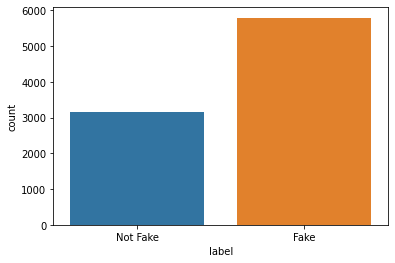

In [88]:
# check the number of 1s and 0s
count = train['label'].value_counts()

print('Fake "1" :', count[1])
print('Not Fake "0":', count[0])

# print the percentage of question where target == 0
print(f'Fake: {count[1]/(count[0] +count[1])* 100}%')
# plot the no of 1's and 0's
g = sns.countplot(train.label)
g.set_xticklabels(['Not Fake', 'Fake'])
plt.show()

## Statement
AHora analizaremos los statement del dataset de entrenamiento por el número de palabras que tienen. Vemos que los textos tienen de media 18 palabras, estando la mayoría de ellos (90%) por debajo de las 30 palabras. Observamos además que hay dos textos mucho más grandes que el resto.

Number of words description
count    8950.000000
mean       18.428939
std        10.327882
min         2.000000
25%        13.000000
50%        17.000000
75%        23.000000
max       539.000000
Name: statement, dtype: float64

Statements with greater number of words
6537     58
6458     58
5825     60
5619     60
3697     62
7579     63
3656     65
817      73
4899    360
3322    539
Name: statement, dtype: int64

Statements with less than 30 words
90.86033519553072


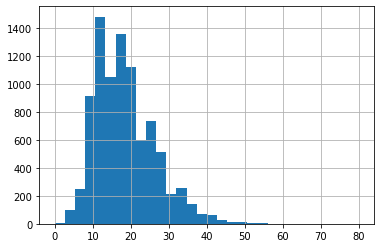

In [89]:
def word_tokenize(s):
    return len(re.findall('\w+', s))
nwords = train.statement.apply(word_tokenize)
nwords.hist(bins=30, range=(0,80))
print('Number of words description')
print(nwords.describe())
print()
print('Statements with greater number of words')
print(nwords.sort_values()[-10:])
print()
print('Statements with less than 30 words')
print(nwords[nwords<30].count()/nwords.count()*100)

## Subject
¿Cuáles son los temás más tratados?

Número de topics por documento
count    8950.000000
mean        2.153631
std         1.352407
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        20.000000
Name: subject, dtype: float64


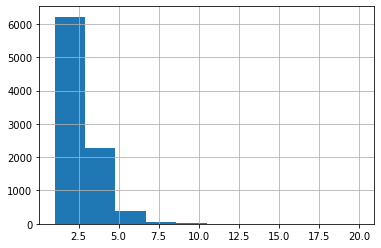


Hay un total de 142 topics

El top 50 topics es:
[('economy', 997), ('health-care', 991), ('taxes', 857), ('federal-budget', 646), ('education', 638), ('jobs', 632), ('state-budget', 612), ('candidates-biography', 572), ('elections', 536), ('immigration', 456), ('foreign-policy', 410), ('crime', 384), ('history', 352), ('energy', 328), ('legal-issues', 304), ('environment', 299), ('guns', 283), ('military', 266), ('job-accomplishments', 261), ('workers', 247), ('terrorism', 246), ('abortion', 230), ('message-machine-2012', 228), ('transportation', 228), ('criminal-justice', 223), ('state-finances', 215), ('states', 194), ('public-health', 190), ('deficit', 186), ('pundits', 183), ('congress', 180), ('women', 177), ('message-machine', 171), ('corrections-and-updates', 170), ('children', 168), ('campaign-finance', 165), ('voting-record', 162), ('medicare', 161), ('stimulus', 158), ('labor', 155), ('income', 150), ('poverty', 150), ('government-regulation', 147), ('ethics', 140), ('relig

<BarContainer object of 15 artists>

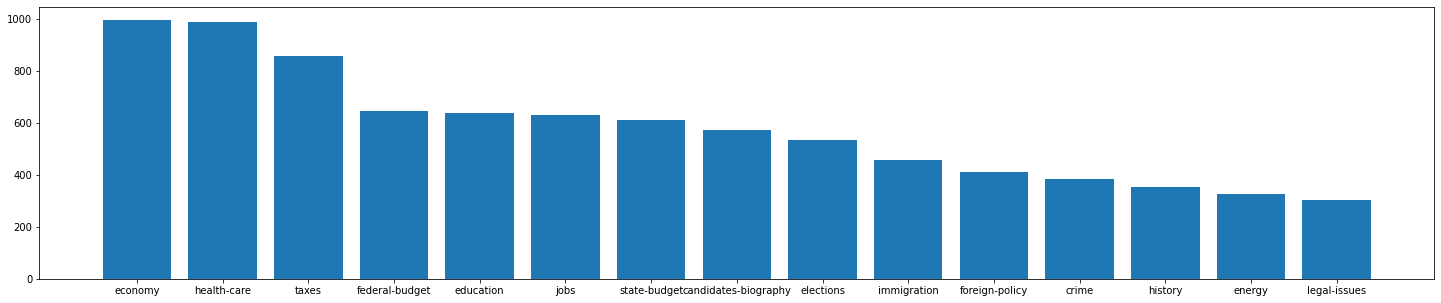

In [94]:
def get_topics(x):
    return x.split(',')
topics = train.subject.apply(get_topics).to_list()
topics = [item for sublist in topics for item in sublist]

print('Número de topics por documento')
print(train.subject.apply(get_topics).apply(len).describe())
train.subject.apply(get_topics).apply(len).hist()
plt.show()
topics = Counter(topics)
print()
print(f'Hay un total de {len(topics.keys())} topics')
print()
n = 50
top_topics = topics.most_common(n)
top_keys = [key for key,count in top_topics]
top_values = [count for key,count in top_topics]
print(f'El top {n} topics es:')
print(top_topics)
plt.subplots(figsize=(25,5))
plt.bar(top_keys[:15],top_values[:15])


¿Cuántos documentos tienen el top n=50 topcis?

In [91]:
def get_top_topics(x):
    topics = set(x.split(','))
    return set(top_keys).intersection(topics)
records_with_top_topics = train.subject.apply(get_top_topics)
no_topic = records_with_top_topics.value_counts()

print(f'Porcentaje de muestras sin topics en el top {n} topics')
print(no_topic[0]/len(train)*100)

Porcentaje de muestras sin topics en el top 50 topics
7.29608938547486


Con el top 50 topics cubrimos más del 90% de los documentos en nuestro dataset.

## Nota importante:
Las proximas secciones muestran el porcentaje de fake news por categoría. Hay que destacar que para que este porcentaje sea significativo, tiene que ser mayor que el porcentaje de fake news en el dataset entero.

## Speaker

In [17]:
count = train.speaker.value_counts().to_frame(name='count')
percentage = (train[train.label==1].speaker.value_counts() / train.speaker.value_counts()).to_frame(name='percentage')

speaker_info = pd.concat([count,percentage], axis=1)

print('Top 10 speakers by number of statement')
print(speaker_info.sort_values(by='count',ascending=False).head(10))
print()
speaker_by_percentage = speaker_info.sort_values(by='percentage',ascending=False)
print('Top 20 speakers by percentage of fake news and more than 10 statements')
print(speaker_by_percentage[speaker_by_percentage['count'] > 10].head(20))
print()

Top 10 speakers by number of statement
                 count  percentage
barack-obama       435    0.535632
donald-trump       247    0.834008
hillary-clinton    204    0.480392
mitt-romney        142    0.718310
john-mccain        139    0.589928
chain-email        128    0.968750
scott-walker       123    0.650407
rick-perry         117    0.717949
rick-scott         105    0.647619
marco-rubio         99    0.676768

Top 20 speakers by percentage of fake news and more than 10 statements
                                             count  percentage
viral-image                                     18    1.000000
americans-prosperity                            15    1.000000
chain-email                                    128    0.968750
rush-limbaugh                                   25    0.960000
national-republican-senatorial-committee        24    0.958333
democratic-congressional-campaign-committee     21    0.952381
ben-carson                                      19    0.947368


Podemos ver como buena parte de las muestras son de Obama, Trum y Hillary Clinton. También como medios asociados a Internet (mail chains o blog posts) o el mismo Trump, tienen un alto porcentaje de fake news.

## Speaker job
Vemos que hay varios valores iguales que solo cambian en las mayúsculas. Además, si supiéramos si hay diferencia o no entre u.s. senator y senator, podríamos utilizar este conocimiento para refinar un poco más. También hay casos bastante específicos como ``Governor of Ohio as of Jan. 10, 2011 `` que seguramente se podrían generalizar más.

In [18]:
train.speaker_job = train.speaker_job.apply(lambda x: x.lower() if type(x)==str else x)
count = train.speaker_job.value_counts().to_frame(name='count')
percentage = (train[train.label==1].speaker_job.value_counts() / train.speaker_job.value_counts()).to_frame(name='percentage')

speaker_job_info = pd.concat([count,percentage], axis=1)

print('Top 10 speaker jobs by number of statement')
print(speaker_job_info.sort_values(by='count',ascending=False).head(10))
print()
speaker_job_by_percentage = speaker_job_info.sort_values(by='percentage',ascending=False)
print('Top 20 speaker jobs by percentage of fake news and more than 10 statements')
print(speaker_job_by_percentage[speaker_job_by_percentage['count'] > 10].head(20))
print()

Top 10 speaker jobs by number of statement
                        count  percentage
u.s. senator              627    0.548644
president                 438    0.536530
governor                  368    0.663043
president-elect           247    0.834008
u.s. representative       230    0.626087
presidential candidate    216    0.495370
state senator             183    0.568306
state representative      153    0.614379
former governor           143    0.720280
senator                   129    0.689922

Top 20 speaker jobs by percentage of fake news and more than 10 statements
                                          count  percentage
radio host                                   26    0.961538
advocacy group                               14    0.928571
milwaukee county sheriff                     11    0.909091
maryland governor                            11    0.909091
member of the u.s. house                     15    0.866667
chairman, republican national committee      19    0.842105

Buena parte de las muestras son de senadores, gobernadores o presidentes. Cabe destacar el alto porcentaje de fake news de los presidentes electos, lo cual nos puede dar una pista de sesgos en nuestro datasets.

## State_info
Hay estados repetidos como Washington DC. Una limpieza de los datos solucionaría este problema.

In [19]:
count = train.state_info.value_counts().to_frame(name='count')
percentage = (train[train.label==1].state_info.value_counts() / train.state_info.value_counts()).to_frame(name='percentage')

state_info = pd.concat([count,percentage], axis=1)

print('Top 10 states by number of statement')
print(state_info.sort_values(by='count',ascending=False).head(10))
print()
state_by_percentage = state_info.sort_values(by='percentage',ascending=False)
print('Top 20 states by percentage of fake news and more than 10 statements')
print(state_by_percentage[state_by_percentage['count'] > 10].head(20))
print()

Top 10 states by number of statement
              count  percentage
Texas           879    0.654152
Florida         853    0.617819
Wisconsin       648    0.703704
New York        579    0.673575
Illinois        487    0.554415
Ohio            408    0.517157
Georgia         381    0.608924
Virginia        368    0.619565
Rhode Island    317    0.618297
Oregon          220    0.595455

Top 20 states by percentage of fake news and more than 10 statements
                  count  percentage
Iowa                 13    0.846154
Indiana              38    0.815789
Pennsylvania         79    0.784810
Minnesota            54    0.777778
Alaska               50    0.760000
Utah                 19    0.736842
Colorado             22    0.727273
Wisconsin           648    0.703704
Massachusetts       167    0.700599
Kansas               13    0.692308
South Carolina       25    0.680000
Arkansas             77    0.675325
Nevada               40    0.675000
New York            579    0.673575
T

## Party affiliation

In [20]:
count = train.party_affiliation.value_counts().to_frame(name='count')
percentage = (train[train.label==1].party_affiliation.value_counts() / train.party_affiliation.value_counts()).to_frame(name='percentage')

party_affiliation_info = pd.concat([count,percentage], axis=1)

print('Top 10 party affiliations by number of statement')
print(party_affiliation_info.sort_values(by='count',ascending=False).head(10))
print()
party_affiliation_by_percentage = party_affiliation_info.sort_values(by='percentage',ascending=False)
print('Top 20 party affiliations by percentage of fake news and more than 10 statements')
print(party_affiliation_by_percentage[party_affiliation_by_percentage['count'] > 10].head(20))
print()

Top 10 party affiliations by number of statement
              count  percentage
republican     3947    0.695212
democrat       2898    0.562112
none           1531    0.693664
organization    197    0.812183
independent     130    0.446154
newsmaker        41    0.536585
journalist       37    0.513514
libertarian      34    0.617647
columnist        32    0.593750
activist         30    0.566667

Top 20 party affiliations by percentage of fake news and more than 10 statements
                count  percentage
organization      197    0.812183
talk-show-host     23    0.739130
republican       3947    0.695212
none             1531    0.693664
libertarian        34    0.617647
columnist          32    0.593750
activist           30    0.566667
democrat         2898    0.562112
newsmaker          41    0.536585
journalist         37    0.513514
independent       130    0.446154
state-official     14    0.428571



In [ ]:
train.groupby(['party_affiliation','label']).size().unstack('label').plot(kind='bar',figsize=(10,10))

Podemos destacar que la mayor parte de muestras pertenecen al partido republicano, demócrata o ``None``. Además, las muestras de los demócratas tienen una tendencia menor a ser falsas.



## Fairness

A la hora de realizar un clasificador de fake news es de especial importancia analizar las features con las que está aprendiendo y averiguar si existe algún tipo de sesgo en ellas. Además, se ha de analizar si realmente se cree conveniente utilizar algunas de ellas para predecir. 

Por ejemplo, a pesar de que en nuestro dataset pueda darse el caso de que la mayor parte de las noticias de Iowa sean falsas, podemos asumir que la "distribución de falsedad" es uniforme en todos los estados. Es decir, no por ser de Iowa se debería asumir que el statement es falso. Por lo tanto, sería conveniente evitar la característica ```state_info``` para no introducir sesgos que no queramos en nuestro sistema.

En cambio, tener en cuenta el ``speaker`` podría ser interesante a la hora de penalizar a personas que tradicionalmente divulgan falsedades.

Estos criterios son discutibles y su adopción o no dependerá del objetivo y contexto del investigador.

# Preprocessing
- preprocessing
- sentiment
- balancing

## Sentiment

Se ha realizado la predicción del sentimiento de los statements entre ``POSITIVE`` y ``NEGATIVE`` usando un modelo basado en transformers fituned para dicha tarea que es el estado del arte en numerosos benchmarks de análisis de sentimiento, [roberta-large](https://huggingface.co/siebert/sentiment-roberta-large-english).

El proceso se ha realizado en otro notebook con el siguiente código:
```
from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")
text = train.statement.apply(lambda x: x[:500]).tolist()

result = []
for i in range(0, len(text), 10):
    if i%300 == 0: print(i)
    text2predict = text[i:i+10]
    result.extend(sentiment_analysis(text2predict))
```

Ejemplo:
```
print(sentiment_analysis(["I love this!", 'I hate you']))
    >>> [{'label': 'POSITIVE', 'score': 0.9988656640052795}, {'label': 'NEGATIVE', 'score': 0.9991401433944702}]
```

## Preprocessing

In [21]:
train_original = train.copy()
test_original = test.copy()

### Topics

In [22]:
values = {}
topic_cols = top_keys
for t in topic_cols:
    values[t] = 0

train = pd.concat([train, pd.DataFrame(columns=topic_cols)]).fillna(value=values)

def convert_topics_to_dummies(x):
    topics_in_row = x.subject.split(',')
    for t in topics_in_row:
        if t in top_keys:
            
            x[t] = 1

    return x

train = train.apply(convert_topics_to_dummies, axis=1)
train.describe()

,label,economy,health-care,taxes,federal-budget,education,jobs,state-budget,candidates-biography,elections,...,income,poverty,government-regulation,ethics,religion,public-safety,polls,government-efficiency,corporations,iraq
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,...,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,0.647486,0.111397,0.110726,0.095754,0.072179,0.071285,0.070615,0.068380,0.063911,0.059888,...,0.016760,0.016760,0.016425,0.015642,0.014860,0.013743,0.013296,0.013184,0.012961,0.012961
std,0.477780,0.314640,0.313810,0.294270,0.258798,0.257315,0.256194,0.252411,0.244607,0.237293,...,0.128377,0.128377,0.127109,0.124095,0.121001,0.116429,0.114546,0.114070,0.113112,0.113112
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Podemos ver la media de veces que aparece cada uno de los topics en el dataset, el mayor de ellos economy con un 11.1%.

### Speaker Job processing
Fill NaN, lowercase and get top 30, rest other.

In [23]:
train.speaker_job.fillna(value='Unknown', inplace=True)

train['speaker_job']=train.speaker_job.apply(lambda x: x.lower())

top_speaker_jobs = train.speaker_job.value_counts().head(30).index.to_list()

train['speaker_job'] = train.speaker_job.apply(lambda x: x if x in top_speaker_jobs else 'other')

speaker_jobs = train.speaker_job.value_counts().index.tolist()
train = pd.get_dummies(train, columns=['speaker_job'])
train.head()

,id,label,statement,subject,speaker,state_info,party_affiliation,sentiment,economy,health-care,...,speaker_job_speaker of the house of representatives,speaker_job_state representative,speaker_job_state senator,speaker_job_u.s. congressman,speaker_job_u.s. house of representatives,speaker_job_u.s. representative,"speaker_job_u.s. representative, florida district 23",speaker_job_u.s. senator,speaker_job_u.s. senator from ohio,speaker_job_unknown
0,81f884c64a7,1.0,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,New York,republican,NEGATIVE,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30c2723a188,0.0,With the resources it takes to execute just ov...,health-care,chris-dodd,Connecticut,democrat,NEGATIVE,0,1,...,0,0,0,0,0,0,0,1,0,0
2,6936b216e5d,0.0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,"Washington, D.C.",democrat,NEGATIVE,0,0,...,0,0,0,0,0,0,0,0,0,0
3,b5cd9195738,1.0,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,none,NEGATIVE,0,0,...,0,0,0,0,0,0,0,0,0,1
4,84f8dac7737,0.0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,Wisconsin,republican,NEGATIVE,0,1,...,0,0,0,0,0,0,0,0,0,1


### State info

Clean NaN, get dummies

In [24]:
train.state_info.fillna(value='Unknown', inplace=True)

top_states = train.state_info.value_counts().head(30).index.to_list()

train['state_info'] = train.state_info.apply(lambda x: x if x in top_states else 'other')

states = train.state_info.value_counts().index.tolist()
train = pd.get_dummies(train, columns=['state_info'])
train.head()


,id,label,statement,subject,speaker,party_affiliation,sentiment,economy,health-care,taxes,...,state_info_Pennsylvania,state_info_Rhode Island,state_info_Tennessee,state_info_Texas,state_info_Unknown,state_info_Vermont,state_info_Virginia,"state_info_Washington, D.C.",state_info_Wisconsin,state_info_other
0,81f884c64a7,1.0,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,republican,NEGATIVE,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30c2723a188,0.0,With the resources it takes to execute just ov...,health-care,chris-dodd,democrat,NEGATIVE,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,6936b216e5d,0.0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,democrat,NEGATIVE,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,b5cd9195738,1.0,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,none,NEGATIVE,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,84f8dac7737,0.0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,republican,NEGATIVE,0,1,0,...,0,0,0,0,0,0,0,0,1,0


### Party Affiliation

Grouping and get dummies

In [25]:
top_parties = train.party_affiliation.value_counts().head(3).index.to_list()

train['party_affiliation'] = train.party_affiliation.apply(lambda x: x if x in top_parties else 'other')

pa = train.party_affiliation.value_counts().index.tolist()
pa

['republican', 'democrat', 'none', 'other']

In [26]:
train = pd.get_dummies(train, columns=['party_affiliation'])
train.head()

,id,label,statement,subject,speaker,sentiment,economy,health-care,taxes,federal-budget,...,state_info_Unknown,state_info_Vermont,state_info_Virginia,"state_info_Washington, D.C.",state_info_Wisconsin,state_info_other,party_affiliation_democrat,party_affiliation_none,party_affiliation_other,party_affiliation_republican
0,81f884c64a7,1.0,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,NEGATIVE,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,30c2723a188,0.0,With the resources it takes to execute just ov...,health-care,chris-dodd,NEGATIVE,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
2,6936b216e5d,0.0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,NEGATIVE,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
3,b5cd9195738,1.0,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NEGATIVE,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,84f8dac7737,0.0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NEGATIVE,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1


### Type conversion

In [110]:
train.sentiment = pd.Categorical(train.sentiment)
train['sentiment'] = train.sentiment.cat.codes
test.sentiment = pd.Categorical(test.sentiment)
test['sentiment'] = test.sentiment.cat.codes

In [28]:
train.label = train.label.astype(int)

Heatmap

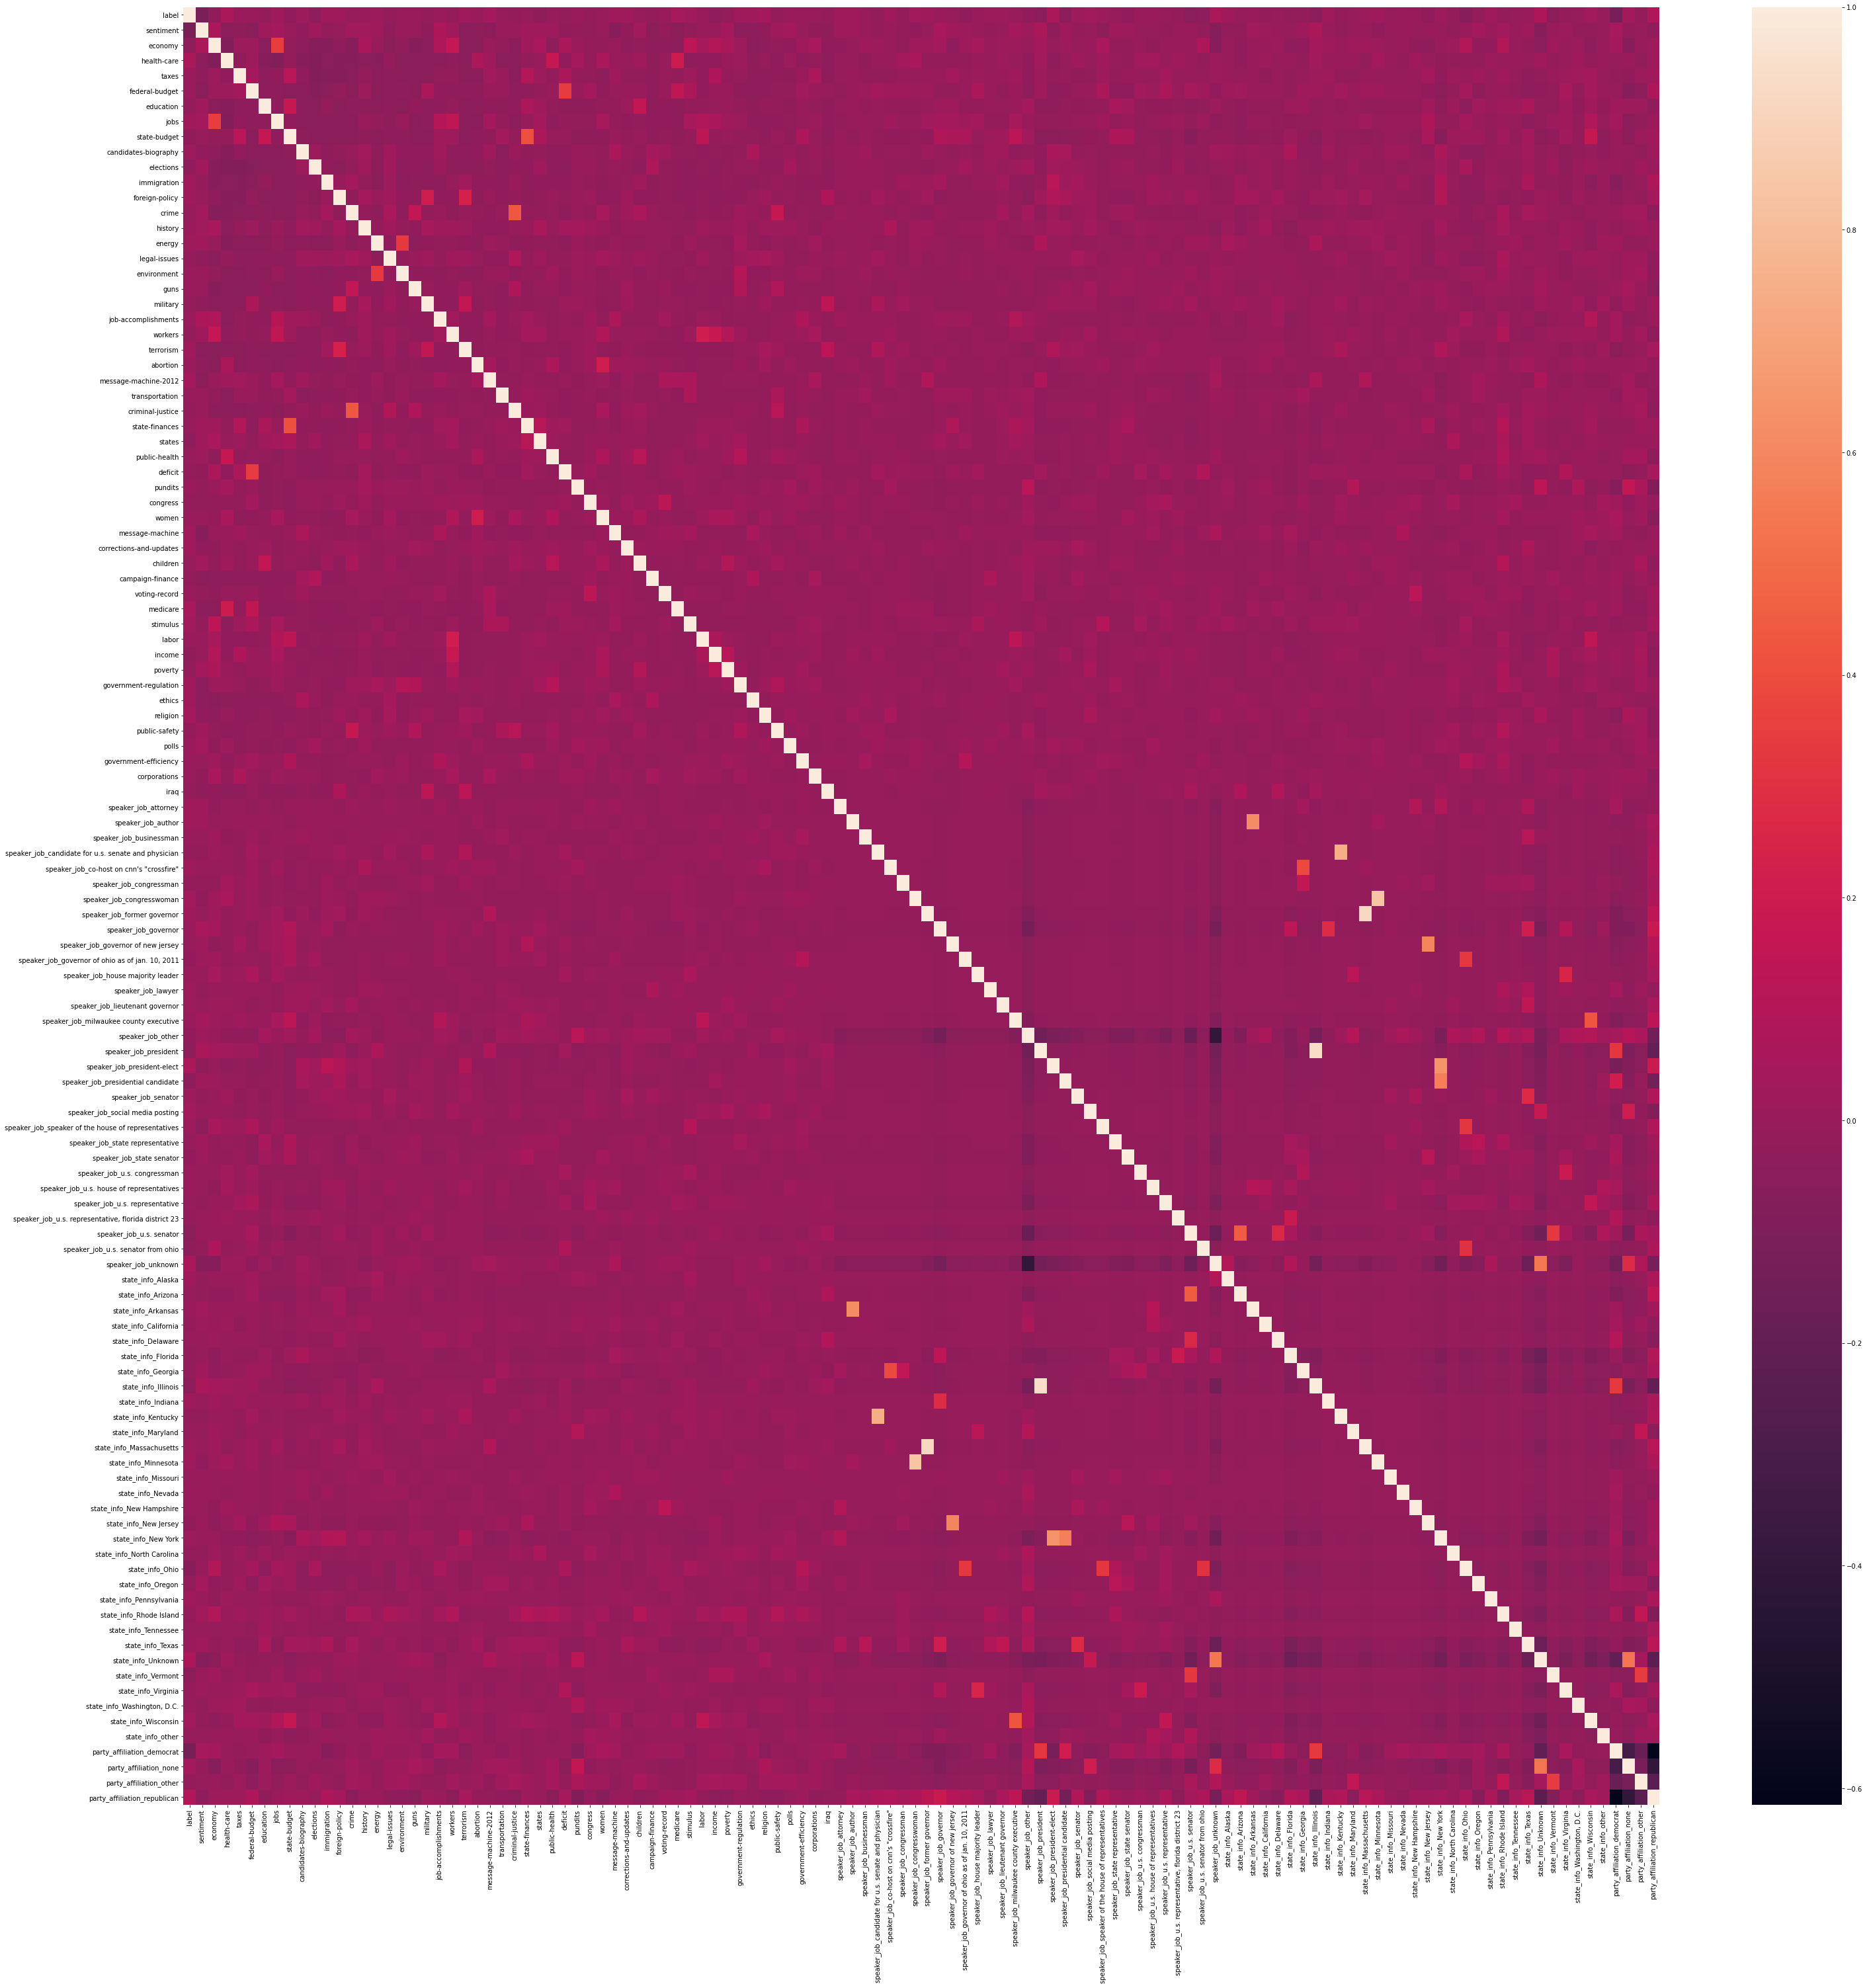

In [29]:
plt.figure(figsize=(50,50))
sns.heatmap(train.corr())
plt.show()

No hay grandes correlaciones con ninguna característica y la label. La mayor de ellas es la correlación negativa con el ser demócrata y el sentimiento (si es 0, negativo, suele tender a ser fake).

In [30]:
train.corr().loc['label'].sort_values(ascending=False).head(10)

label                           1.000000
party_affiliation_republican    0.088729
state_info_Unknown              0.077155
speaker_job_president-elect     0.065772
speaker_job_unknown             0.065094
health-care                     0.062860
medicare                        0.050597
message-machine-2012            0.045083
party_affiliation_none          0.043909
religion                        0.042300
Name: label, dtype: float64

In [31]:
train.corr().loc['label'].sort_values(ascending=True).head(10)

party_affiliation_democrat           -0.123658
sentiment                            -0.105509
state_info_Ohio                      -0.059620
speaker_job_u.s. senator             -0.056785
speaker_job_president                -0.052683
speaker_job_presidential candidate   -0.050072
state_info_Illinois                  -0.046732
state_info_Vermont                   -0.041742
speaker_job_u.s. senator from ohio   -0.036401
states                               -0.034709
Name: label, dtype: float64

### Preprocessing test dataset

In [32]:
test_df = test.copy()

values = {}
for t in topic_cols:
    values[t] = 0

test_df = pd.concat([test_df, pd.DataFrame(columns=topic_cols)]).fillna(value=values)

test_df = test_df.apply(convert_topics_to_dummies, axis=1)
test_df.speaker_job.fillna(value='Unknown', inplace=True)

test_df['speaker_job']=test_df.speaker_job.apply(lambda x: x.lower())


test_df['speaker_job'] = test_df.speaker_job.apply(lambda x: x if x in top_speaker_jobs else 'other')

test_df = pd.get_dummies(test_df, columns=['speaker_job'])


test_df.state_info.fillna(value='Unknown', inplace=True)


test_df['state_info'] = test_df.state_info.apply(lambda x: x if x in top_states else 'other')


test_df = pd.get_dummies(test_df, columns=['state_info'])


test_df['party_affiliation'] = test_df.party_affiliation.apply(lambda x: x if x in top_parties else 'other')

test_df = pd.get_dummies(test_df, columns=['party_affiliation'])
test_df.sentiment = test_df.sentiment.astype(int)
test_df.head()

,id,statement,subject,speaker,sentiment,economy,health-care,taxes,federal-budget,education,...,state_info_Unknown,state_info_Vermont,state_info_Virginia,"state_info_Washington, D.C.",state_info_Wisconsin,state_info_other,party_affiliation_democrat,party_affiliation_none,party_affiliation_other,party_affiliation_republican
0,dc32e5ffa8b,Five members of [the Common Cause Georgia] boa...,"campaign-finance,ethics,government-regulation",kasim-reed,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,aa49bb41cab,Theres no negative advertising in my campaign ...,elections,bill-mccollum,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,dddc8d12ac1,Leticia Van de Putte voted to give illegal imm...,"health-care,immigration,public-health",dan-patrick,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,bcfe8f51667,Fiorinas plan would mean slashing Social Secur...,"federal-budget,medicare,social-security",barbara-boxer,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,eedbbaff5ab,"By the end of his first term, President Obama ...","federal-budget,new-hampshire-2012",mitt-romney,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [33]:
train.to_csv('train_preprocessed.csv',index=False)
test_df.to_csv('test_preprocessed.csv',index=False)

# Modeling



In [33]:
train = pd.read_csv('train_preprocessed.csv')
test = pd.read_csv('test_preprocessed.csv')

In [34]:
# d = train.drop(columns=['label'])
# label = train['label']

# rus = RandomUnderSampler(random_state=0)
# rus.fit(d, label)
# train_resampled, y_resampled = rus.fit_resample(d, label)
# train_resampled['label'] = y_resampled

# train_resampled.label.value_counts()

## Experimentos con solo texto

In [35]:
train_text = train[['id','statement','label']]
test_text = test[['id','statement']]
test_text['label'] = 1    #For make it easier to make predictions

<ipython-input-35-37bc33d47c2d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_text['label'] = 1    #For make it easier to make predictions


In [36]:
train_text, dev_text = train_test_split(train_text, test_size=0.1, random_state=RANDOM_SEED)

In [6]:
#Creates a dataset which will be used to feed to transformers
class FakeNewsDataset(data.Dataset):

    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')#,zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [9]:
BATCH_SIZE = [64,32,16]
MAX_LENGTH = [512,256,128]
EPOCHS = 8
LR = [5e-5, 3e-5, 2e-5]
MODEL = ['distilroberta-base','roberta-base','roberta-large']


In [ ]:
max_bs = BATCH_SIZE[-1]
max_ml = MAX_LENGTH[-1]
last_model = MODEL[0]
for model, lr, bs,ml in itertools.product(MODEL,LR, BATCH_SIZE, MAX_LENGTH):
    PATH = f'{model}_{bs}_{lr}_{ml}'
    
    if model == last_model:
        if bs < max_bs:
            print(f'Skipping batch size of {bs}')
            continue
        elif ml < max_ml:
            print(f'Skipping max length of {ml}')
            continue
    else:
        last_model= model
        max_bs = 4
        
    tokenizer = AutoTokenizer.from_pretrained(model,use_fast=True)
    train_encodings = tokenizer(train_text.statement.tolist(), truncation=True, padding=True, max_length= ml)
    val_encodings = tokenizer(dev_text.statement.tolist(), truncation=True, padding=True, max_length= ml)
    test_encodings = tokenizer(test_text.statement.tolist(), truncation=True, padding=True, max_length= ml)

    #Creating data loader for training data
    trainDataset        = FakeNewsDataset(train_encodings,train_text.label.tolist())

    #Creating data loader for development data
    developmentDataset  = FakeNewsDataset(val_encodings,dev_text.label.tolist())

    #Creating data loader for test data
    testDataset         = FakeNewsDataset(test_encodings, test_text.label.tolist())


    training_args = TrainingArguments(
        output_dir=f'./results/{PATH}',                   # output directory
        num_train_epochs=EPOCHS,                  # total number of training epochs
        per_device_train_batch_size=bs,   # batch size per device during training
        per_device_eval_batch_size=bs,    # batch size for evaluation
        warmup_steps=100,                         # number of warmup steps for learning rate scheduler
        weight_decay=0.01,                        # strength of weight decay
        logging_dir=f'./logs/{PATH}',                     # directory for storing logs
        logging_steps=10,                         # when to print log
        load_best_model_at_end=True,
        learning_rate = lr

    )

    num_labels = len(set(train_text.label.tolist()))
    print(f'Num labels: {num_labels}')

    model =AutoModelForSequenceClassification.from_pretrained(model, num_labels=num_labels)
    trainer = Trainer(
        model=model,                              # the instantiated 🤗 Transformers model to be trained
        args=training_args,                       # training arguments, defined above
        train_dataset=trainDataset,              # training dataset
        eval_dataset=developmentDataset,                 # evaluation dataset 
        compute_metrics = compute_metrics
    )
#     trainer.train()
    try:
        trainer.train()
    except:
        print(f'Exception with {PATH} during training')
        continue
    max_bs = bs
    max_ml = ml
    trainer.save_model(f"./results/{PATH}/best_model") # save best model
    try:
        print(trainer.evaluate())
    except:
        print(f'Exception with {PATH} during evaluating')
        
        
    
    PredictionOutput = trainer.predict(developmentDataset)
    result = np.argmax(PredictionOutput.predictions, axis=1)

    #Printing classification report for dev dataset (Evaluating the model on Dev set)
    print('=======================================================')
    print(PATH)
    print('=======================================================')
    print(classification_report(developmentDataset[:]['label'].tolist(), result, target_names= CLASS_NAMES))

    PredictionOutput = trainer.predict(testDataset)
    result = np.argmax(PredictionOutput.predictions, axis=1)

    ids = test.id
    df = pd.DataFrame(ids, columns=['id'])
    df['label'] = result
    df.to_csv(f'submissions/submission_{PATH}.csv', index=False)

Num labels: 2


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight'

Step,Training Loss
10,0.671600
20,0.658400
30,0.662100
40,0.628900
50,0.628900
60,0.629700
70,0.642900
80,0.605400


### Best Model


El mejor modelo ha resultado ser distilroberta-base con un batch size de 64, learning rate 2e-05 y max token length de 512, entrenado en el dataset **desbalanceado**. Ha obtenido una puntuación de 0.62904 en Kaggle.

In [15]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base',use_fast=True)
train_encodings = tokenizer(train_text.statement.tolist(), truncation=True, padding=True, max_length= 512)
val_encodings = tokenizer(dev_text.statement.tolist(), truncation=True, padding=True, max_length= 512)
test_encodings = tokenizer(test_text.statement.tolist(), truncation=True, padding=True, max_length= 512)

#Creating data loader for training data
trainDataset        = FakeNewsDataset(train_encodings,train_text.label.tolist())

#Creating data loader for development data
developmentDataset  = FakeNewsDataset(val_encodings,dev_text.label.tolist())

#Creating data loader for test data
testDataset         = FakeNewsDataset(test_encodings, test_text.label.tolist())


training_args = TrainingArguments(
    output_dir=f'./results/best_model',                   # output directory
    num_train_epochs=5,                  # total number of training epochs
    per_device_train_batch_size=64,   # batch size per device during training
    per_device_eval_batch_size=64,    # batch size for evaluation
    warmup_steps=100,                         # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                        # strength of weight decay
    logging_dir=f'./logs/best_model',                     # directory for storing logs
    logging_steps=10,                         # when to print log
    load_best_model_at_end=True,
    learning_rate = 2e-05

)

num_labels = len(set(train_text.label.tolist()))
print(f'Num labels: {num_labels}')
model =AutoModelForSequenceClassification.from_pretrained('./results/distilroberta-base_64_2e-05_512/best_model/', num_labels=num_labels)

trainer = Trainer(
        model=model,                              # the instantiated 🤗 Transformers model to be trained
        args=training_args,                       # training arguments, defined above
        train_dataset=trainDataset,              # training dataset
        eval_dataset=developmentDataset,                 # evaluation dataset 
        compute_metrics = compute_metrics
    )

PredictionOutput = trainer.predict(developmentDataset)
result = np.argmax(PredictionOutput.predictions, axis=1)

#Printing classification report for dev dataset (Evaluating the model on Dev set)

print(classification_report(developmentDataset[:]['label'].tolist(), result, target_names= CLASS_NAMES))

Num labels: 2


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


              precision    recall  f1-score   support

     no-fake       0.49      0.56      0.52       305
        fake       0.75      0.71      0.73       590

    accuracy                           0.65       895
   macro avg       0.62      0.63      0.63       895
weighted avg       0.67      0.65      0.66       895



## Custom transformer

In [77]:
from transformers import RobertaModel
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
class RobertaForSequenceClassificationCustom(RobertaPreTrainedModel):
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.classifier = RobertaClassificationHead(config)
        self.init_weights()


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        extra_features=None
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = outputs[0]
        logits = self.classifier(sequence_output,extra_features)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                self.config.problem_type = "regression"
            elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                self.config.problem_type = "single_label_classification"
            else:
                self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
    
class RobertaClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)
        self.input_size_extrafeats     = config.hidden_size + len(train.drop(['statement','label','id'],axis=1).columns)
        self.dense_extra                     = nn.Linear( self.input_size_extrafeats,  self.input_size_extrafeats)
        self.out_proj_extra                  = nn.Linear( self.input_size_extrafeats, config.num_labels)

    def forward(self, features, extra_features,**kwargs):
        x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        x = torch.cat((x, extra_features) , dim=1)
        x = self.dropout(x)
        x = self.dense_extra(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj_extra(x)
        return x

In [78]:
train = pd.read_csv('train_preprocessed.csv')
test = pd.read_csv('test_preprocessed.csv')

In [79]:
train.drop(columns=['subject','speaker'],inplace=True)
test.drop(columns=['subject','speaker'],inplace=True)
train, dev = train_test_split(train, test_size=0.1, random_state=RANDOM_SEED)
test['label'] = 1

In [80]:
#Creates a dataset which will be used to feed to RoBERTa
class FakeNewsDataset(data.Dataset):

    def __init__(self, encodings, labels, extra_feats):
        self.encodings = encodings
        self.labels = labels
        self.extra_feats = extra_feats

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        item['extra_features'] = torch.tensor(self.extra_feats[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)
train_encodings = tokenizer(train.statement.tolist(), truncation=True, padding=True, max_length= 512)
val_encodings = tokenizer(dev.statement.tolist(), truncation=True, padding=True, max_length= 512)
test_encodings = tokenizer(test.statement.tolist(), truncation=True, padding=True, max_length= 512)
#Creating data loader for training data
trainDataset        = FakeNewsDataset(train_encodings,train.label.tolist(), train.drop(['statement','label','id'],axis=1).to_numpy())

#Creating data loader for development data
developmentDataset  = FakeNewsDataset(val_encodings,dev.label.tolist(),dev.drop(['statement','label','id'],axis=1).to_numpy())

#Creating data loader for test data
testDataset         = FakeNewsDataset(test_encodings, test.label.tolist(),test.drop(['statement','label','id'],axis=1).to_numpy())

In [81]:
training_args = TrainingArguments(
    output_dir='./resultsCustom',                   # output directory
    num_train_epochs=6,                  # total number of training epochs
    per_device_train_batch_size=64,   # batch size per device during training
    per_device_eval_batch_size=64,    # batch size for evaluation
    warmup_steps=100,                         # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                        # strength of weight decay
    logging_dir='./logsCustom',                     # directory for storing logs
    logging_steps=10,                         # when to print log
    load_best_model_at_end=True,
)

num_labels = len(set(train.label.tolist()))
print(f'Num labels: {num_labels}')

model = RobertaForSequenceClassificationCustom.from_pretrained('distilroberta-base', num_labels=num_labels)

trainer = Trainer(
    model=model,                              # the instantiated 🤗 Transformers model to be trained
    args=training_args,                       # training arguments, defined above
    train_dataset=trainDataset,              # training dataset
    eval_dataset=developmentDataset,                 # evaluation dataset 
    compute_metrics = compute_metrics
)
trainer.train()

Num labels: 2


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassificationCustom: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassificationCustom from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassificationCustom from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassificationCustom were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['

Step,Training Loss
10,0.676200
20,0.659500
30,0.657200
40,0.630600
50,0.631600
60,0.630600
70,0.629000
80,0.612500
90,0.628900
100,0.620600


TrainOutput(global_step=378, training_loss=0.489095875510463, metrics={'train_runtime': 173.4633, 'train_samples_per_second': 2.179, 'total_flos': 2211774730891200.0, 'epoch': 6.0, 'init_mem_cpu_alloc_delta': -154415104, 'init_mem_gpu_alloc_delta': 332922368, 'init_mem_cpu_peaked_delta': 154415104, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 6746112, 'train_mem_gpu_alloc_delta': 1000032256, 'train_mem_cpu_peaked_delta': 81920, 'train_mem_gpu_peaked_delta': 2456929280})

In [82]:
trainer.save_model(f"./resultsCustom/best_model") # save best model

In [83]:
trainer.evaluate()

{'eval_loss': 0.8115352988243103,
 'eval_accuracy': 0.6681564245810055,
 'eval_f1': 0.6370536646909191,
 'eval_precision': 0.6352862734976557,
 'eval_recall': 0.6398166157265908,
 'eval_runtime': 3.1109,
 'eval_samples_per_second': 287.698,
 'epoch': 6.0,
 'eval_mem_cpu_alloc_delta': 90112,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 57344,
 'eval_mem_gpu_peaked_delta': 2316774400}

In [84]:
PredictionOutput = trainer.predict(testDataset)

result = np.argmax(PredictionOutput.predictions, axis=1)

ids = test.id

df = pd.DataFrame(ids, columns=['id'])

df['label'] = result

df.to_csv(f'submissions/distilroberta_custom.csv', index=False)

/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Este model personalizado con extra features alcanza un score de 0.62369, menos que modelo sin extra features.

## NLP Clásico

In [1]:
import string
from collections import Counter

import pandas as pd
import numpy as np

import pickle
from joblib import dump,load
import joblib

from imblearn.under_sampling import RandomUnderSampler

#Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline


#NLP
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from textblob import TextBlob
import scipy
import spacy
from spacy import displacy
import gensim

#Evaluation metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Data splitter
from sklearn.model_selection import train_test_split

# Best feature selector utility
from sklearn.feature_selection import SelectKBest, f_classif

#MultiLabelEncoding
from sklearn.preprocessing import MultiLabelBinarizer

# Estimators
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

/home/alejandro/.local/share/virtualenvs/retofinal-NMVcSmJN/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Características del texto (NLP)

In [2]:
def custom_tokenizer(words):
    """Preprocessing tokens as seen in the lexical notebook"""
    
    tokens = word_tokenize(words.lower())
    porter = PorterStemmer()
    lemmas = [porter.stem(t) for t in tokens]
    stoplist = stopwords.words('english')
    lemmas_clean = [w for w in lemmas if w not in stoplist]
    punctuation = set(string.punctuation)
    lemmas_punct = [w for w in lemmas_clean if  w not in punctuation]
    return lemmas_punct

class LexicalStats (BaseEstimator, TransformerMixin):
    """Extract lexical features from each document"""
    
    def number_sentences(self, doc):
        sentences = sent_tokenize(doc, language='english')
        return len(sentences)
    
    def number_words(self,doc):
        words = word_tokenize(doc.lower())
        punctuation = set(string.punctuation)
        return len([w for w in words if  w not in punctuation])
    
    def number_word_repetitions(self,doc):
        words_tokenized = custom_tokenizer(doc)
        return sum([(v-1) for k,v in Counter(words_tokenized).items() if v > 1])
        
    
    def fit(self, x, y=None):
        return self

    def transform(self, docs):
        return [{'length': len(doc),
                 'num_words': self.number_words(doc),
                 'num_word_repetitions': self.number_word_repetitions(doc),
                 'num_sentences': self.number_sentences(doc)}
                for doc in docs]

class PosStats(BaseEstimator, TransformerMixin):
    
    """Obtain number of tokens with POS categories"""

    def stats(self, doc):
        tokens = custom_tokenizer(doc)
        tagged = pos_tag(tokens, tagset='universal')
        counts = Counter(tag for word,tag in tagged)
        total = sum(counts.values())
        
        pos_features = {'NOUN': 0, 'ADJ': 0, 'VERB': 0, 'ADV': 0, 'CONJ': 0, 
                        'ADP': 0, 'PRON':0, 'NUM': 0}
        
        pos_dic = dict((tag, float(count)/total) for tag,count in counts.items())
        for k in pos_dic:
            if k in pos_features:
                pos_features[k] = pos_dic[k]
        return pos_features
    
    def transform(self, docs, y=None):
        return [self.stats(doc) for doc in docs]
    
    def fit(self, docs, y=None):
        """Returns `self` unless something different happens in train and test"""
        return self

ngrams_featurizer = Pipeline([
  ('count_vectorizer',  CountVectorizer(ngram_range = (1, 3), tokenizer=custom_tokenizer)),
  ('tfidf_transformer', TfidfTransformer())
])

class SentimentStats (BaseEstimator, TransformerMixin):
    """Predicts polarity of each document."""
    
    def exclamation_count(self,doc):
        e = [v for k,v in Counter(doc).items() if k in ['!']]
        ex_count= e[0] if e else 0
        return ex_count
    
    def fit(self, x, y=None):
        return self

    def transform(self, docs):
        return [
            {'polarity':TextBlob(doc).sentiment.polarity,
             'num_exclamations': self.exclamation_count(doc)}
            for doc in docs]

class NerStats(BaseEstimator, TransformerMixin):
    """NER stats"""
    
    def __init__(self):
        self.nlp = spacy.load("en_core_web_lg")
    
    def stats(self, doc):
        
        processed_doc = self.nlp(doc)
        counts = Counter(x.label_ for x in processed_doc.ents)
        total = sum(counts.values())
    
        ner_features = {'CARDINAL': 0, 'DATE': 0, 'EVENT': 0, 'FAC': 0, 'GPE': 0, 
                        'LANGUAGE': 0, 'LAW':0, 'LOC': 0, 'MONEY': 0, 'NORP': 0,
                        'ORDINAL':0, 'ORG':0, 'PERCENT': 0, 'PERSON':0, 'QUANTITY':0,
                        'TIME':0, 'WORK_OF_ART':0}
        
        ner_dic = dict((tag, float(count)/total) for tag,count in counts.items())
        for k in ner_dic:
            if k in ner_features:
                ner_features[k] = ner_dic[k]
        return ner_features
    
    def transform(self, docs, y=None):
        return [self.stats(doc) for doc in docs]
    
    def fit(self, docs, y=None):
        return self
    
lda = ('lda', Pipeline([
    ('count',CountVectorizer(tokenizer=custom_tokenizer)),
    ('lda',  LatentDirichletAllocation(n_components=4,
                                       max_iter=5,
                                       learning_method='online',
                                       learning_offset=50.,
                                       random_state=0)
    )
]))

class Word2Vec (BaseEstimator, TransformerMixin):
    """W2V"""
    def __init__(self):
        self.word2vec_path = "/home/alejandro/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
        self.word2vec = gensim.models.KeyedVectors.load_word2vec_format(self.word2vec_path, binary=True)
    
    def get_average_word2vec(self, doc, vector, generate_missing=False, k=300):
        
        tokens_list = custom_tokenizer(doc)
        
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
        length = len(vectorized)
        summed = np.sum(vectorized, axis=0)
        averaged = np.divide(summed, length)
        return averaged
    
    def get_word2vec_embeddings(self, doc):
        embeddings = self.get_average_word2vec(doc, self.word2vec)
        return list(embeddings)
    
    def fit(self, x, y=None):
        return self

    def transform(self, docs):
        return [self.get_word2vec_embeddings(doc) for doc in docs]


w2v_pipeline = Pipeline([
    ('features', FeatureUnion([
            ('lexical_stats', Pipeline([('stats', LexicalStats()),
                                        ('vectors', DictVectorizer())
                                       ])),
            ('w2v',Word2Vec()),
            ('ngrams', ngrams_featurizer),
            ('pos_stats', Pipeline([('pos_stats', PosStats()),
                                    ('vectors', DictVectorizer())
                                   ])),
            ('sentiment', Pipeline([('sentiment_stats', SentimentStats()),
                                            ('vectors', DictVectorizer())
                                   ])),
            ('ner_stats', Pipeline([('ner_stats', NerStats()),
                                            ('vectors', DictVectorizer())
                                   ])),
            
            ('lda', Pipeline([('count', CountVectorizer(tokenizer=custom_tokenizer)),
                              ('lda',  LatentDirichletAllocation(n_components=4, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                             ]))
       
    ]))
])

### Construcción de Modelos

In [3]:
# Algunas funciones necesarias

def get_top_n_subjects(subjects,n):
    global_counter = Counter()
    for subject_list in subjects:
        subjects_separated = subject_list.split(',')
        global_counter = global_counter + Counter(subjects_separated)  
    
    top_topics = global_counter.most_common(n)
    top_keys = [key for key,count in top_topics]
    top_values = [count for key,count in top_topics]
    
    return list(zip(top_keys,top_values))

def set_top_subjects(subjects):
    topics = set(subjects.split(','))
    return set(top_keys).intersection(topics)

def party_affiliation(pa):
    wanted = ['republican','democrat','none']
    if pa in wanted:
        return pa
    else:
        return 'other'

def model_evaluation(models, x_train, x_test, y_train, y_test):
    
    results = []
    
    for model in models:
        print(model)
        
        name = type(model).__name__
        
        model.fit(x_train,y_train)
        
        predicted = model.predict(x_test)
        expected = y_test
        
        f1score = f1_score(expected, predicted, average="weighted")
        precisionscore = precision_score(expected, predicted, average="weighted")
        recallscore = recall_score(expected, predicted, average="weighted")
        accuracyscore = accuracy_score(expected, predicted)
        
        print(f' f1-score: {f1score}')
        print(f' Precision: {precisionscore}')
        print(f' Recall: {recallscore}')
        print(f' Accuracy: {accuracyscore}')

        # Confusion matrix
        plot_confusion_matrix(model, x_test, expected)
        plt.show()
        print(confusion_matrix(expected, predicted))

        # Report
        print(classification_report(expected, predicted))
        print()

        #CV
        print("Cross Validation:")
        cv = StratifiedKFold(5, shuffle=True, random_state=33)
        score_types = ['accuracy']
        
        for st in score_types:
            scores = cross_val_score(model, x_train, y_train, cv=cv, n_jobs=-1, scoring=st)
            print(f'{st} scores in every iteration: {scores}')
            print(f"%s: %0.4f (+/- %0.4f)" % (st, scores.mean(), scores.std() * 4))
            print('-----------------------------------------')
            print()
        
        

        results.append({'classifier':name,'f1_score':f1score,
                        'precision':precisionscore,'recall':recallscore,
                        'accuracy':accuracyscore
                       })
    
    return pd.DataFrame(results).sort_values(by='f1_score', ascending=False)

In [17]:
# Models
LR = LogisticRegression(n_jobs=-1)
lsvc = LinearSVC(dual=False)
models = [LR,lsvc]

In [5]:
#Prepare data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test_nolabel.csv")

df_test["label"] = "test" 
df_total = pd.concat([df_train,df_test],ignore_index=True)
df_total

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican
...,...,...,...,...,...,...,...,...
12781,e050483b866,test,Ken Hodges badly botched this investigation an...,"job-accomplishments,message-machine",rob-teilhet,attorney,Georgia,democrat
12782,6221e28aa63,test,"Ten years ago, John McCain offered a bill that...",ethics,barack-obama,President,Illinois,democrat
12783,954dc0f0b5d,test,"Says his bill, HB 97, would prevent the use of...","abortion,health-care",matt-gaetz,State Representative,Florida,republican
12784,2fa476b0d2f,test,Its been 14 years since a president or a vice ...,sports,candy-crowley,CNN host,NaN,none


In [7]:
top_topics = get_top_n_subjects(df_total['subject'],50)
top_keys, _ = zip(*top_topics)
df_total['subject'] = df_total['subject'].apply(set_top_subjects)
df_total['party_affiliation'] = df_total['party_affiliation'].apply(party_affiliation)
df_total

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation
0,81f884c64a7,1,China is in the South China Sea and (building)...,"{military, foreign-policy}",donald-trump,President-Elect,New York,republican
1,30c2723a188,0,With the resources it takes to execute just ov...,{health-care},chris-dodd,U.S. senator,Connecticut,democrat
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"{pundits, taxes, corporations}",donna-brazile,Political commentator,"Washington, D.C.",democrat
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"{legal-issues, candidates-biography, children,...",rebecca-bradley,NaN,NaN,none
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"{labor, state-budget, health-care}",republican-party-wisconsin,NaN,Wisconsin,republican
...,...,...,...,...,...,...,...,...
12781,e050483b866,test,Ken Hodges badly botched this investigation an...,"{message-machine, job-accomplishments}",rob-teilhet,attorney,Georgia,democrat
12782,6221e28aa63,test,"Ten years ago, John McCain offered a bill that...",{ethics},barack-obama,President,Illinois,democrat
12783,954dc0f0b5d,test,"Says his bill, HB 97, would prevent the use of...","{abortion, health-care}",matt-gaetz,State Representative,Florida,republican
12784,2fa476b0d2f,test,Its been 14 years since a president or a vice ...,{},candy-crowley,CNN host,NaN,none


In [8]:
mlb = MultiLabelBinarizer(sparse_output=True)

df_total = df_total.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df_total.pop('subject')),
                index=df_total.index,
                columns=mlb.classes_))

df_total.head()

,id,label,statement,speaker,speaker_job,state_info,party_affiliation,abortion,campaign-finance,candidates-biography,...,state-budget,state-finances,states,stimulus,taxes,terrorism,transportation,voting-record,women,workers
0,81f884c64a7,1,China is in the South China Sea and (building)...,donald-trump,President-Elect,New York,republican,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30c2723a188,0,With the resources it takes to execute just ov...,chris-dodd,U.S. senator,Connecticut,democrat,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,donna-brazile,Political commentator,"Washington, D.C.",democrat,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,rebecca-bradley,NaN,NaN,none,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,republican-party-wisconsin,NaN,Wisconsin,republican,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [9]:
df_total = pd.get_dummies(df_total, columns=['speaker','party_affiliation','speaker_job','state_info'])
df_total.head()

,id,label,statement,abortion,campaign-finance,candidates-biography,children,city-government,climate-change,congress,...,state_info_Washington DC,state_info_Washington state,"state_info_Washington, D.C.","state_info_Washington, D.C.",state_info_West Virginia,state_info_Wisconsin,state_info_Wisconsin,state_info_Wyoming,state_info_ohio,state_info_the United States
0,81f884c64a7,1,China is in the South China Sea and (building)...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30c2723a188,0,With the resources it takes to execute just ov...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
# Now I have the same feature encodings in both training and test dataset
df_copy = df_total.copy()
df_train = df_copy[df_copy.label!="test"]
df_test = df_copy[df_copy.label=="test"]

In [12]:
statements = df_train['statement'].values
statements_transformed = w2v_pipeline.fit_transform(statements)
features = statements_transformed

y = df_train['label'].values.astype(int)
other_features = df_train.drop(columns=['statement','id','label'])
other_features.head()

,abortion,campaign-finance,candidates-biography,children,city-government,climate-change,congress,corporations,corrections-and-updates,crime,...,state_info_Washington DC,state_info_Washington state,"state_info_Washington, D.C.","state_info_Washington, D.C.",state_info_West Virginia,state_info_Wisconsin,state_info_Wisconsin,state_info_Wyoming,state_info_ohio,state_info_the United States
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
X = scipy.sparse.hstack((features, other_features))

In [14]:
kbest = SelectKBest(k=5000).fit(X, y)
X_kbest = kbest.transform(X)

/home/alejandro/.local/share/virtualenvs/retofinal-NMVcSmJN/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X_kbest,y,test_size=0.25, random_state=33)

LogisticRegression(n_jobs=-1)
 f1-score: 0.6282479333213316
 Precision: 0.6327311039322315
 Recall: 0.6621983914209115
 Accuracy: 0.6621983914209115


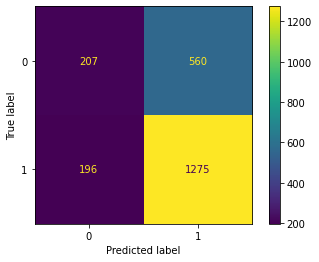

[[ 207  560]
 [ 196 1275]]
              precision    recall  f1-score   support

           0       0.51      0.27      0.35       767
           1       0.69      0.87      0.77      1471

    accuracy                           0.66      2238
   macro avg       0.60      0.57      0.56      2238
weighted avg       0.63      0.66      0.63      2238


Cross Validation:
accuracy scores in every iteration: [0.66567386 0.66790767 0.66169896 0.66318927 0.68330849]
accuracy: 0.6684 (+/- 0.0311)
-----------------------------------------

LinearSVC(dual=False)
 f1-score: 0.6952110598231048
 Precision: 0.7035246010665185
 Recall: 0.7162645218945487
 Accuracy: 0.7162645218945487


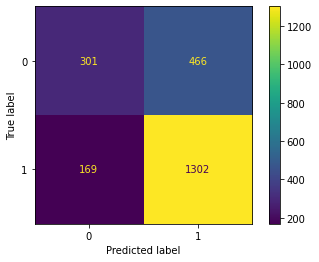

[[ 301  466]
 [ 169 1302]]
              precision    recall  f1-score   support

           0       0.64      0.39      0.49       767
           1       0.74      0.89      0.80      1471

    accuracy                           0.72      2238
   macro avg       0.69      0.64      0.65      2238
weighted avg       0.70      0.72      0.70      2238


Cross Validation:
accuracy scores in every iteration: [0.71183917 0.68875652 0.7071535  0.7242921  0.71385991]
accuracy: 0.7092 (+/- 0.0466)
-----------------------------------------



In [18]:
results_df = model_evaluation(models, x_train, x_test, y_train, y_test)

In [19]:
results_df

,classifier,f1_score,precision,recall,accuracy
1,LinearSVC,0.695211,0.703525,0.716265,0.716265
0,LogisticRegression,0.628248,0.632731,0.662198,0.662198


#### Optimización Hiperparámetros

In [20]:
models = [LR,lsvc]
# Feature spaces for each model

#LR
param_grid_LR = {'C': np.logspace(-2, 3, 10),
                'random_state':[33],
                'solver': ['newton-cg'],
                'max_iter': [2000]
                }


#LSVC
param_grid_lsvc =  {'C': np.logspace(-2, 3, 20),
                    'dual': [False]
                   }



param_grids = [param_grid_LR,param_grid_lsvc]

In [21]:
scores = ['f1']

best_params = []

for model,param_grid in zip(models,param_grids):
    print(model)
    print(param_grid)
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        # cv = the fold of the cross-validation cv, defaulted to 5
        gs = GridSearchCV(model, param_grid, cv=5, scoring='%s_weighted' % score)
        gs.fit(x_train, y_train)

        print("Best parameters set found on development set:")
        print()
        best_params.append(gs.best_params_)
        print(gs.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = gs.cv_results_['mean_test_score']
        stds = gs.cv_results_['std_test_score']

        for mean_score, std_score, params in zip(means, stds, gs.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean_score, std_score * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, gs.predict(x_test)
        print(classification_report(y_true, y_pred))
        print()

LogisticRegression(n_jobs=-1)
{'C': array([1.00000000e-02, 3.59381366e-02, 1.29154967e-01, 4.64158883e-01,
       1.66810054e+00, 5.99484250e+00, 2.15443469e+01, 7.74263683e+01,
       2.78255940e+02, 1.00000000e+03]), 'random_state': [33], 'solver': ['newton-cg'], 'max_iter': [2000]}
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 278.2559402207126, 'max_iter': 2000, 'random_state': 33, 'solver': 'newton-cg'}

Grid scores on development set:

0.559 (+/-0.015) for {'C': 0.01, 'max_iter': 2000, 'random_state': 33, 'solver': 'newton-cg'}
0.606 (+/-0.012) for {'C': 0.03593813663804628, 'max_iter': 2000, 'random_state': 33, 'solver': 'newton-cg'}
0.630 (+/-0.020) for {'C': 0.1291549665014884, 'max_iter': 2000, 'random_state': 33, 'solver': 'newton-cg'}
0.649 (+/-0.025) for {'C': 0.464158883361278, 'max_iter': 2000, 'random_state': 33, 'solver': 'newton-cg'}
0.664 (+/-0.026) for {'C': 1.6681005372000592, 'max_iter': 2000, 'random_state': 33, 'solver': 

In [22]:
LR_tuned = LogisticRegression(**best_params[0])
lsvc_tuned = LinearSVC(**best_params[1])

models_tuned = [LR_tuned,lsvc_tuned]

LogisticRegression(C=278.2559402207126, max_iter=2000, random_state=33,
                   solver='newton-cg')
 f1-score: 0.7220111677038178
 Precision: 0.7215616337477821
 Recall: 0.7310098302055407
 Accuracy: 0.7310098302055407


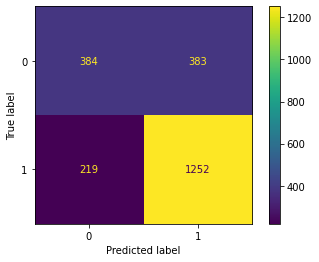

[[ 384  383]
 [ 219 1252]]
              precision    recall  f1-score   support

           0       0.64      0.50      0.56       767
           1       0.77      0.85      0.81      1471

    accuracy                           0.73      2238
   macro avg       0.70      0.68      0.68      2238
weighted avg       0.72      0.73      0.72      2238


Cross Validation:
accuracy scores in every iteration: [0.73194341 0.7259866  0.71535022 0.7414307  0.73248882]
accuracy: 0.7294 (+/- 0.0344)
-----------------------------------------

LinearSVC(C=14.38449888287663, dual=False)
 f1-score: 0.7223785886632096
 Precision: 0.7256529798899696
 Recall: 0.7354781054512958
 Accuracy: 0.7354781054512958


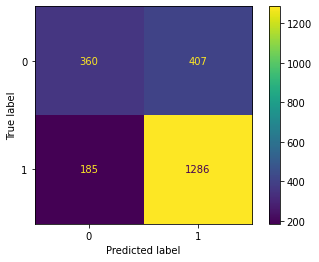

[[ 360  407]
 [ 185 1286]]
              precision    recall  f1-score   support

           0       0.66      0.47      0.55       767
           1       0.76      0.87      0.81      1471

    accuracy                           0.74      2238
   macro avg       0.71      0.67      0.68      2238
weighted avg       0.73      0.74      0.72      2238


Cross Validation:
accuracy scores in every iteration: [0.73417722 0.7282204  0.71609538 0.73472429 0.73025335]
accuracy: 0.7287 (+/- 0.0270)
-----------------------------------------



In [23]:
results_tuned_df = model_evaluation(models_tuned, x_train, x_test, y_train, y_test)

In [24]:
results_tuned_df

,classifier,f1_score,precision,recall,accuracy
1,LinearSVC,0.722379,0.725653,0.735478,0.735478
0,LogisticRegression,0.722011,0.721562,0.731010,0.731010
